In [1]:
!pip install transformers
!pip install bert-extractive-summarizer

In [2]:
import pandas as pd
import numpy as np

In [3]:
# # Loading Dependencies
# import os
# import tensorflow as tf
# from tensorflow.keras.layers import Dense, Input
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.models import Model
# from tensorflow.keras.callbacks import ModelCheckpoint
# from kaggle_datasets import KaggleDatasets
# import transformers

# from tokenizers import BertWordPieceTokenizer

In [4]:
# Dataset Mentah

dataset_raw_df = pd.read_csv ("/kaggle/input/indonesian-news-dataset-splitted/Indonesian News Dataset Splitted.csv")
dataset_raw_df.head()

,Unnamed: 0,id,source,title,image,url,content,date,embedding,created_at,updated_at,summary
0,0,83,tempo,"Depo Plumpang Terbakar, Anggota DPR Minta Pert...",https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698528/depo-pl...,"TEMPO.CO, Jakarta - Anggota Komisi VII DPR RI ...",2023-03-04 06:18:13+00,"[-0.01590039,-0.034130897,0.005732614,-0.01853...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,Anggota Komisi VII DPR RI Rofik Hananto menyay...
1,1,84,tempo,Jokowi Perintahkan Wapres Ma'ruf Amin Tinjau L...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698522/jokowi-...,"TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",2023-03-04 06:04:38+00,"[-0.017608976,-0.021786924,0.01547983,-0.00932...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,Presiden Joko Widodo telah memerintahkan Wakil...
2,2,85,tempo,HNW Mendukung Jamaah Umroh First Travel Dapatk...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698527/hnw-men...,INFO NASIONAL - Wakil Ketua MPR RI Dr. H. M. H...,2023-03-04 06:18:04+00,"[0.00841488,-0.023665192,0.006762431,-0.013723...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,Wakil Ketua MPR RI Dr. H. M. Hidayat Nur Wahid...
3,3,86,tempo,Tim Dokkes Polri Telah Terima 14 Kantong Jenaz...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698540/tim-dok...,"TEMPO.CO, Jakarta - Tim Kedokteran dan Kesehat...",2023-03-04 06:44:10+00,"[-0.012671886,-0.0039057182,0.019575326,-0.016...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,Tim Kedokteran dan Kesehatan (Dokkes) Polri te...
4,4,87,tempo,Bamsoet Ajak Komunitas Otomotif Kembangkan Per...,https://statik.tempo.co/data/2023/03/04/id_118...,https://nasional.tempo.co/read/1698536/bamsoet...,INFO NASIONAL - Ketua MPR RI sekaligus Ketua U...,2023-03-04 06:38:57+00,"[-0.015486176,-0.0125719,-0.0122843925,-0.0343...",2023-03-04 07:03:39.039332,2023-03-04 07:03:39.039332,Ketua MPR RI Bambang Soesatyo telah diangkat s...


In [5]:
# Memilih kolom yang digunakan pada dataset (cuma butuh text sama summary)

dataset_df = dataset_raw_df[["content", "summary"]]
dataset_df

,content,summary
0,"TEMPO.CO, Jakarta - Anggota Komisi VII DPR RI ...",Anggota Komisi VII DPR RI Rofik Hananto menyay...
1,"TEMPO.CO, Jakarta - Presiden Joko Widodo atau ...",Presiden Joko Widodo telah memerintahkan Wakil...
2,INFO NASIONAL - Wakil Ketua MPR RI Dr. H. M. H...,Wakil Ketua MPR RI Dr. H. M. Hidayat Nur Wahid...
3,"TEMPO.CO, Jakarta - Tim Kedokteran dan Kesehat...",Tim Kedokteran dan Kesehatan (Dokkes) Polri te...
4,INFO NASIONAL - Ketua MPR RI sekaligus Ketua U...,Ketua MPR RI Bambang Soesatyo telah diangkat s...
...,...,...
995,JAKARTA - Indonesia Award Magazine memberi pen...,MNC Life Assurance meraih penghargaan Indonesi...
996,JAKARTA - Uang mencurigakan sebesar Rp300 tril...,Menkopolhukam Mahfud MD mengklarifikasi bahwa ...
997,JAKARTA - Harga minyak akhirnya naik lebih dar...,Harga minyak dunia naik lebih dari 1% di akhir...
998,Ketua Umum Partai NasDem Surya Paloh menegask...,"Ketua Umum NasDem, Surya Paloh, menyerahkan ke..."


In [6]:
# Bersih-bersih kalau ada whitespace atau ada simbol simbol yang aneh

import re

def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row

In [7]:
# Di apply bersih-bersih yang tadi

brief_cleaning1 = text_strip(dataset_df['content'])
brief_cleaning2 = text_strip(dataset_df['summary'])

In [8]:
# Pake library spacy buat batch (ini kepake nanti sih pas pake dataset full, datanya kan cuma 1000, batch sizenya 5000 jadi rada gaguna sekarang)

import spacy
from spacy.lang.id import Indonesian
from time import time

nlp = Indonesian()  # Load Indonesian spaCy model

t = time()

text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000)]
print('Time to clean up text: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up text: 0.08 mins


In [9]:
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000)]
print('Time to clean up summary: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up summary: 0.08 mins


In [10]:
text[25]

'info nasional menteri pertanian syahrul yasin limpo meminta organisasi rumah petani nelayan nusantara rpnn untuk menggunakan anggaran kredit usaha rakyat kur sebagai dukungan bersama dalam meningkatkan produktivitas saya berharap rpnn mampu menggunakan kur sebagai dukungan bersama terhadap jalannya produksi dan usaha tani kami tidak ada bantuan karena yang ada hanya gagasan kata syahrul saat membuka rapat kerja nasional rpnn di komplek pusat pelatihan manajemen kepemimpinan ppmk ciawi bogor jawa barat sabtu maret 2023.syahrul menjelaskan kredit usaha rakyat adalah program yang dicanangkan presiden jokowi dalam membantu petani mendapatkan akses perkreditan program ini menjangkau semua petani dari berbagai kalangan di seluruh indonesia.terutama kalangan petani milenial yang memiliki kemampuan dalam mengunakan teknologi digitalisasi saya katakan salah satu fasilitas yang diberikan bapak presiden itu adalah kredit usaha rakyat tentu aksesnya dengan pengawalan yang sangat ketat dan rasanya

In [11]:
summary[25]

'_START_ menteri pertanian syahrul yasin limpo meminta organisasi rumah petani nelayan nusantara rpnn untuk menggunakan anggaran kredit usaha rakyat kur sebagai dukungan bersama dalam meningkatkan produktivitas kur adalah program yang dicanangkan presiden jokowi untuk membantu petani mendapatkan akses perkreditan ketua rpnn slamet mengatakan organisasinya siap mendukung kesuksesan program pemerintah dan membela kepentingan petani. _END_'

In [12]:
dataset_df['cleaned_text'] = pd.Series(text)
dataset_df['cleaned_summary'] = pd.Series(summary)

/tmp/ipykernel_34/3441996377.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['cleaned_text'] = pd.Series(text)
/tmp/ipykernel_34/3441996377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_df['cleaned_summary'] = pd.Series(summary)


In [13]:
# Menghitung panjang text & summary

text_count = []
summary_count = []

for sent in dataset_df['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in dataset_df['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [14]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

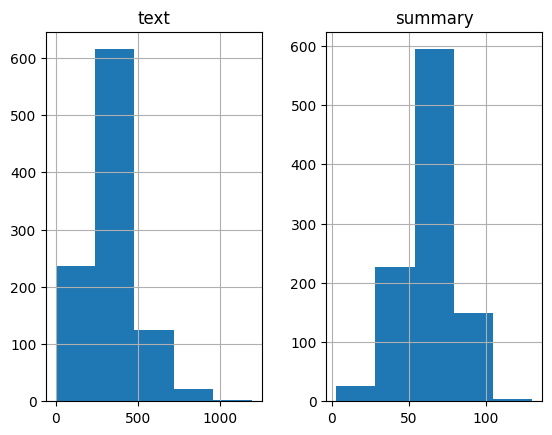

In [15]:
#Dijadiin graph biar keliatan rata-rata text itu panjangnya berapa

import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [16]:
# Dari graph kelihatan kalo mayoritas summary tuh ada di rentan 100 kata
# Check how much % of summary have 0-100 words

cnt=0
for i in dataset_df['cleaned_summary']:
    if(len(i.split())<=100):
        cnt=cnt+1
print("% of Text that have 0 - 100 word = ", (round(cnt/len(dataset_df['cleaned_summary']) * 100, 2)), "%")

% of Text that have 0 - 100 word =  99.5 %


In [17]:
# Dari graph kelihatan kalo mayoritas text tuh ada di rentan 900 kata
# Check how much % of text have 0-900 words

cnt=0
for i in dataset_df['cleaned_text']:
    if(len(i.split())<=900):
        cnt=cnt+1
print("% of Text that have 0 - 900 word = ", (round(cnt/len(dataset_df['cleaned_text']) * 100, 2)), "%")

% of Text that have 0 - 900 word =  99.5 %


In [18]:
# Model to summarize the text between 0-100 words for Summary and 0-900 words for Text
# Diset max nya untuk buang outlier
max_text_len=900
max_summary_len=100

In [19]:
# Select the Summaries and Text between max len defined above

cleaned_text =np.array(dataset_df['cleaned_text'])
cleaned_summary=np.array(dataset_df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [20]:
post_pre.head()

,text,summary
0,tempo.co jakarta anggota komisi vii dpr ri rof...,_START_ anggota komisi vii dpr ri rofik hanant...
1,tempo.co jakarta presiden joko widodo atau jok...,_START_ presiden joko widodo telah memerintahk...
2,info nasional wakil ketua mpr ri dr hidayat nu...,_START_ wakil ketua mpr ri dr hidayat nur wahi...
3,tempo.co jakarta tim kedokteran dan kesehatan ...,_START_ tim kedokteran dan kesehatan dokkes po...
4,info nasional ketua mpr ri sekaligus ketua umu...,_START_ ketua mpr ri bambang soesatyo telah di...


In [21]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [22]:
post_pre.head()

,text,summary
0,tempo.co jakarta anggota komisi vii dpr ri rof...,sostok _START_ anggota komisi vii dpr ri rofik...
1,tempo.co jakarta presiden joko widodo atau jok...,sostok _START_ presiden joko widodo telah meme...
2,info nasional wakil ketua mpr ri dr hidayat nu...,sostok _START_ wakil ketua mpr ri dr hidayat n...
3,tempo.co jakarta tim kedokteran dan kesehatan ...,sostok _START_ tim kedokteran dan kesehatan do...
4,info nasional ketua mpr ri sekaligus ketua umu...,sostok _START_ ketua mpr ri bambang soesatyo t...


In [23]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [24]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from tensorflow.keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

2024-04-17 13:38:05.931644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 13:38:05.931758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 13:38:06.058307: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.13324687955909
Total Coverage of rare words: 5.578265188045592


In [26]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 7009


In [27]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [28]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.95152013147083
Total Coverage of rare words: 17.55944782038843


In [29]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 1684


We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [30]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [31]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [32]:
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, TFBertModel
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model

In [33]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [34]:
# Since the DistilBERT model expects input in a specific format, we need to wrap the transformer in a custom layer to handle the input conversion

class TransformerLayer(Layer):
    def __init__(self, transformer, **kwargs):
        super(TransformerLayer, self).__init__(**kwargs)
        self.transformer = transformer

    def call(self, inputs):
        input_word_ids_tf = tf.convert_to_tensor(inputs)
        return self.transformer(input_ids=input_word_ids_tf)[0]

def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    
    # Wrap the transformer in the custom layer
    sequence_output = TransformerLayer(transformer)(input_word_ids)
    
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [35]:
%%time
with strategy.scope():
    transformer_layer = (
        TFBertModel.from_pretrained("bert-base-multilingual-cased")
    )
    model2 = build_model(transformer_layer, max_len=192)
model2.summary()

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_word_ids (InputLayer)     │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_layer               │ (None, 192, 768)       │             0 │
│ (TransformerLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ get_item (GetItem)              │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

CPU times: user 24.2 s, sys: 2.27 s, total: 26.5 s
Wall time: 28.1 s
